# Importing packages

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
from google.colab import files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


# Installing UGent Panno font

Before running there are a few steps that need to be taken.

Download this: https://www.ugent.be/intranet/nl/op-het-werk/communicatie/huisstijl-presentaties/huisstijl/panno-text.zip
Unzip 'panno-text.zip'

Open and unzip '150831-ugentpannotext-v300-truetype.zip'

Upload the 'UGentPannoText-Normal' to this drive in the local directory!!!! (on the left bar, click the folder-icon, upload the 'UGentPannoText-Normal')

In [ ]:
font_files = fm.findSystemFonts('.')

for font_file in font_files:
    fm.fontManager.addfont(font_file)
print(font_files)
plt.rc('font', family='UGent Panno Text')

['/content/UGentPannoText-SemiBold.ttf', '/content/UGentPannoText-SemiLight.ttf', '/content/UGentPannoText-Normal.ttf', '/content/UGentPannoText-Medium.ttf']


# Defining plot layout

In [ ]:
plt.style.use('bmh')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Model definition

In [ ]:
def CNNK(kmer, tax, epochsize):
    print(f'Initiating training, validation and testing on {tax} level with {kmer}.')

    class mydataset(Dataset):
        def __init__(self, x, y):
            self.x = torch.tensor(x, dtype=torch.float32, device='cpu')
            self.y = torch.tensor(y, dtype=torch.long, device='cpu')
            self.length = self.x.shape[0]

        def __getitem__(self, idx):
            return self.x[idx], self.y[idx]

        def __len__(self):
            return self.length

    class ConvoNet(nn.Module):
        def __init__(self, input_shape, output_shape):
            super(ConvoNet, self).__init__()
            # First layer
            # Input shape = (100, 1, 125)
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=8, stride=1)
            self.relu = nn.ReLU()
            self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
            self.fc1 = nn.Linear(((input_shape - 1*(8 - 1) - 1)//1 + 1), output_shape)

        def forward(self, x):
            out = self.conv1(x)
            out = self.relu(out)
            out = self.pool(out)

            out = out.view(out.size(0), -1)  # flatten
            out = self.fc1(out)
            return out

    print('Model constructed...')

    # Load the existed Training & Validation & Testing Dataset
    base_path = '/content/drive/MyDrive/BachelorsProject/FinalModels/5AMBI/'

    # These files are all in my google drive
    TrainX = np.load(f'{base_path}Train_X_{kmer}5A.npy')
    TrainY = np.load(f'{base_path}Train_Y_{tax}5A.npy')
    TestX = np.load(f'{base_path}Test_X_{kmer}5A.npy')
    TestY = np.load(f'{base_path}Test_Y_{tax}5A.npy')
    ValX = np.load(f'{base_path}Validation_X_{kmer}5A.npy')
    ValY = np.load(f'{base_path}Validation_Y_{tax}5A.npy')
    print('Training, test and validation datasets are loaded...')

    batches = 100
    trainset = mydataset(TrainX, TrainY)
    valset = mydataset(ValX, ValY)
    testset = mydataset(TestX, TestY)
    trainloader = DataLoader(trainset, batch_size=batches, shuffle=True)
    valloader = DataLoader(valset, batch_size=batches, shuffle=False)
    testloader = DataLoader(testset, batch_size=batches, shuffle=False)
    print('Loading trainset, trainloader, testset, testloader ...')

    learning_rate = 0.001
    epochs = epochsize
    input_size = TrainX.shape[1]
    output_size = len(np.unique(TrainY))
    model = ConvoNet(input_shape=input_size, output_shape=output_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    print('Setting hyperparameters...')

    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []

    print('Training model...')
    for epoch in range(epochs):
        # Training loop
        model.train()
        training_loss = 0.0
        correct = 0
        total = 0
        for j, (x_train, y_train) in enumerate(trainloader):
            # calculate output
            x_train = x_train.unsqueeze(1)
            output = model(x_train)

            # calculate loss
            loss = loss_fn(output, y_train)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training loss and accuracy
            training_loss += loss.item() * x_train.size(0)
            output_tags = torch.argmax(output, dim=1)
            targets = y_train
            correct += (output_tags == targets).sum().item()
            total += y_train.size(0)

        # Print training statistics
        epoch_loss = training_loss / len(trainloader.dataset)
        epoch_acc = 100. * correct / total
        print(f'Epoch [{epoch + 1}] Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%')

        # Store the training loss and training accuracy
        training_losses.append(epoch_loss)
        training_accuracies.append(epoch_acc)

        # Validation loop
        model.eval()
        validation_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for j, (x_val, y_val) in enumerate(valloader):
                x_val = x_val.unsqueeze(1)
                output = model(x_val)
                loss = loss_fn(output, y_val)
                # Calculate validation loss and accuracy
                validation_loss += loss.item() * x_val.size(0)
                output_tags = torch.argmax(output, dim=1)
                targets = y_val
                correct += (output_tags == targets).sum().item()
                total += y_val.size(0)

        # Print validation statistics
        epoch_val_loss = validation_loss / len(valloader.dataset)
        epoch_val_acc = 100. * correct / total
        print(f'Epoch [{epoch + 1}] Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.2f}%')

        # Store the validation loss and validation accuracy
        validation_losses.append(epoch_val_loss)
        validation_accuracies.append(epoch_val_acc)

    # Testing
    with torch.no_grad():
        y_pred = []
        y_true = []
        # simple accuracy as above
        for x_test, y_test in testloader:
            x_test = x_test.unsqueeze(1)
            test_output = model(x_test)
            y_pred += torch.argmax(test_output, dim=1).tolist()
            y_true += y_test.tolist()
        report_dict = metrics.classification_report(y_true, y_pred, digits=3)
        print(report_dict)

    plt.plot(training_losses, label='Training', color='#1E64C8', linewidth=1)
    plt.plot(validation_losses, label='Validation', color='black', linewidth=1)
    plt.title(f'Training and Validation Loss of the CNN on {tax} level with {kmer}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (in %)')
    plt.legend()
    plt.savefig(f'CNNK{tax}{kmer}Loss5A.svg')
    files.download(f'CNNK{tax}{kmer}Loss5A.svg') 
    plt.show()

    plt.plot(training_accuracies, label='Training', color='#1E64C8', linewidth=1)
    plt.plot(validation_accuracies, label='Validation', color='black', linewidth=1)
    plt.title(f'Training and Validation Accuracy of the CNN on {tax} level with {kmer}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (in %)')
    plt.legend()
    plt.savefig(f'CNNK{tax}{kmer}Accuracy5A.svg')
    files.download(f'CNNK{tax}{kmer}Accuracy5A.svg') 
    plt.show()
    print(f'Training, validation and testing on {tax} level with {kmer} is completed.')

# 3mer

Initiating training, validation and testing on PHYLUM level with 3mer.
Model constructed...
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 0.9615, Training Accuracy: 69.14%
Epoch [1] Validation Loss: 0.8745, Validation Accuracy: 69.72%
Epoch [2] Training Loss: 0.8616, Training Accuracy: 70.81%
Epoch [2] Validation Loss: 0.8742, Validation Accuracy: 69.72%
Epoch [3] Training Loss: 0.8600, Training Accuracy: 70.81%
Epoch [3] Validation Loss: 0.8710, Validation Accuracy: 69.72%
Epoch [4] Training Loss: 0.8563, Training Accuracy: 70.81%
Epoch [4] Validation Loss: 0.8665, Validation Accuracy: 69.72%
Epoch [5] Training Loss: 0.8482, Training Accuracy: 70.81%
Epoch [5] Validation Loss: 0.8521, Validation Accuracy: 69.72%
Epoch [6] Training Loss: 0.8323, Training Accuracy: 70.81%
Epoch [6] Validation Loss: 0.8291, Validation Accuracy: 69.72%
Epoch [7] Training Loss

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

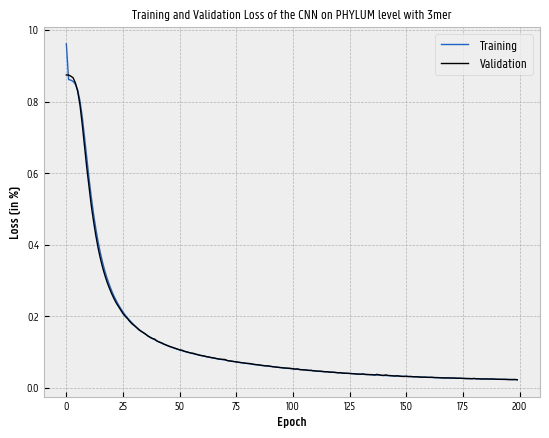

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

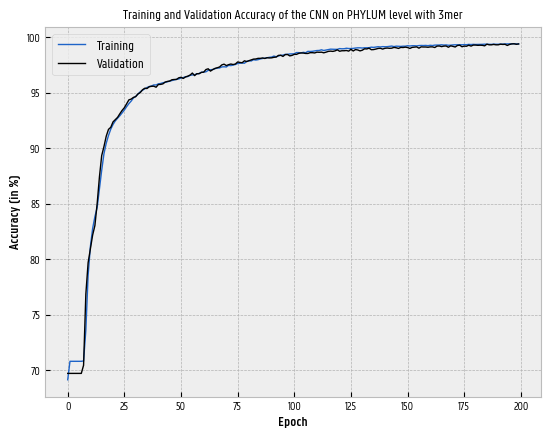

Training, validation and testing on PHYLUM level with 3mer is completed.


In [ ]:
CNNK('3mer', 'PHYLUM', 200)

Initiating training, validation and testing on CLASS level with 3mer.
Model constructed...
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 1.2617, Training Accuracy: 69.23%
Epoch [1] Validation Loss: 1.0782, Validation Accuracy: 69.72%
Epoch [2] Training Loss: 1.0529, Training Accuracy: 70.81%
Epoch [2] Validation Loss: 1.0757, Validation Accuracy: 69.72%
Epoch [3] Training Loss: 1.0508, Training Accuracy: 70.81%
Epoch [3] Validation Loss: 1.0726, Validation Accuracy: 69.72%
Epoch [4] Training Loss: 1.0469, Training Accuracy: 70.81%
Epoch [4] Validation Loss: 1.0694, Validation Accuracy: 69.72%
Epoch [5] Training Loss: 1.0390, Training Accuracy: 70.81%
Epoch [5] Validation Loss: 1.0554, Validation Accuracy: 69.72%
Epoch [6] Training Loss: 1.0232, Training Accuracy: 70.81%
Epoch [6] Validation Loss: 1.0350, Validation Accuracy: 69.72%
Epoch [7] Training Loss:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

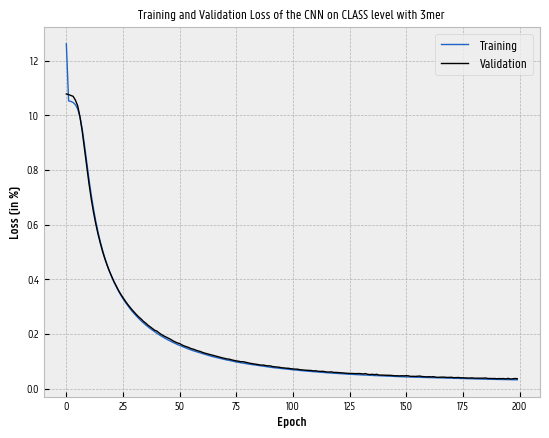

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

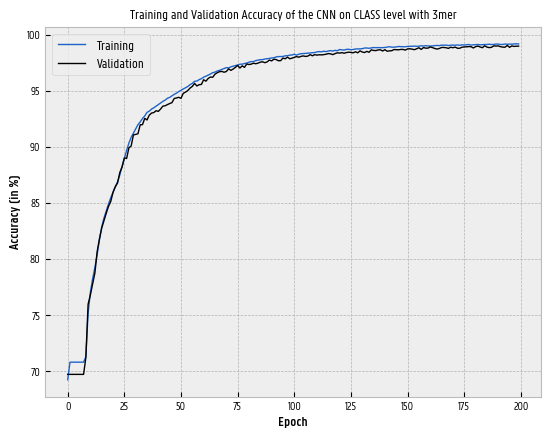

Training, validation and testing on CLASS level with 3mer is completed.


In [ ]:
CNNK('3mer', 'CLASS', 200)

Initiating training, validation and testing on ORDER level with 3mer.
Model constructed...
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 2.4058, Training Accuracy: 27.17%
Epoch [1] Validation Loss: 2.2943, Validation Accuracy: 29.61%
Epoch [2] Training Loss: 2.2594, Training Accuracy: 31.41%
Epoch [2] Validation Loss: 2.2882, Validation Accuracy: 29.61%
Epoch [3] Training Loss: 2.2504, Training Accuracy: 31.41%
Epoch [3] Validation Loss: 2.2752, Validation Accuracy: 29.61%
Epoch [4] Training Loss: 2.2296, Training Accuracy: 31.41%
Epoch [4] Validation Loss: 2.2442, Validation Accuracy: 29.61%
Epoch [5] Training Loss: 2.1868, Training Accuracy: 31.41%
Epoch [5] Validation Loss: 2.1850, Validation Accuracy: 29.61%
Epoch [6] Training Loss: 2.1137, Training Accuracy: 31.41%
Epoch [6] Validation Loss: 2.0944, Validation Accuracy: 29.82%
Epoch [7] Training Loss:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

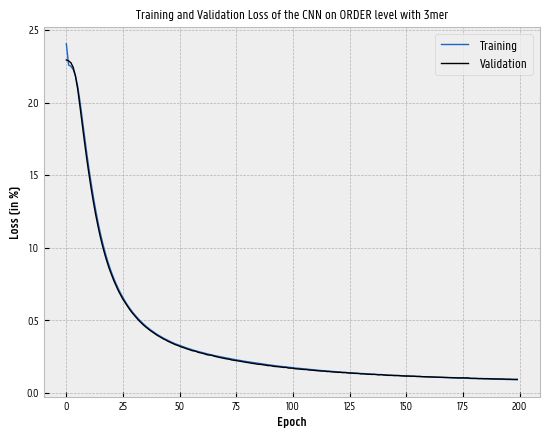

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

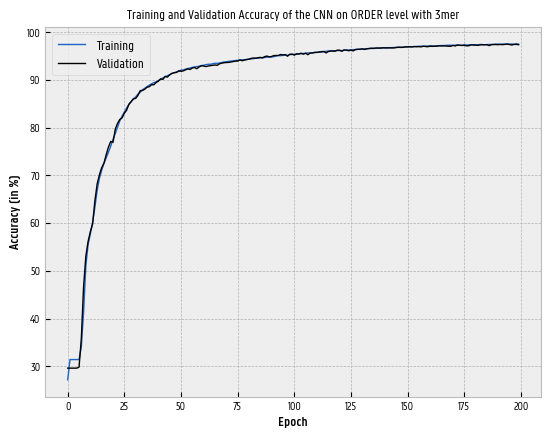

Training, validation and testing on ORDER level with 3mer is completed.


In [ ]:
CNNK('3mer', 'ORDER', 200)

Initiating training, validation and testing on FAMILY level with 3mer.
Model constructed...
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 3.0433, Training Accuracy: 13.71%
Epoch [1] Validation Loss: 3.0064, Validation Accuracy: 15.14%
Epoch [2] Training Loss: 3.0067, Training Accuracy: 14.84%
Epoch [2] Validation Loss: 3.0038, Validation Accuracy: 15.14%
Epoch [3] Training Loss: 3.0055, Training Accuracy: 14.84%
Epoch [3] Validation Loss: 3.0048, Validation Accuracy: 15.14%
Epoch [4] Training Loss: 3.0033, Training Accuracy: 14.84%
Epoch [4] Validation Loss: 3.0000, Validation Accuracy: 15.14%
Epoch [5] Training Loss: 2.9987, Training Accuracy: 14.84%
Epoch [5] Validation Loss: 2.9926, Validation Accuracy: 15.14%
Epoch [6] Training Loss: 2.9900, Training Accuracy: 14.84%
Epoch [6] Validation Loss: 2.9798, Validation Accuracy: 15.14%
Epoch [7] Training Loss

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

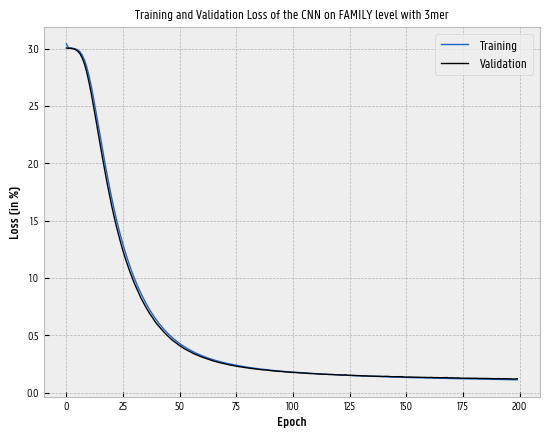

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

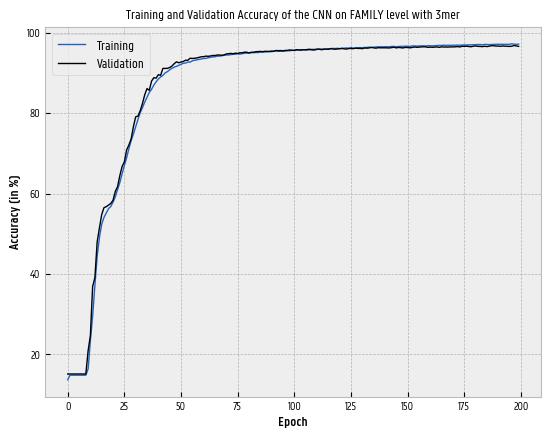

Training, validation and testing on FAMILY level with 3mer is completed.


In [ ]:
CNNK('3mer', 'FAMILY', 200)

Initiating training, validation and testing on GENUS level with 3mer.
Model constructed...
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 3.3802, Training Accuracy: 14.54%
Epoch [1] Validation Loss: 3.2839, Validation Accuracy: 15.14%
Epoch [2] Training Loss: 3.2924, Training Accuracy: 14.84%
Epoch [2] Validation Loss: 3.2826, Validation Accuracy: 15.14%
Epoch [3] Training Loss: 3.2908, Training Accuracy: 14.84%
Epoch [3] Validation Loss: 3.2811, Validation Accuracy: 15.14%
Epoch [4] Training Loss: 3.2871, Training Accuracy: 14.84%
Epoch [4] Validation Loss: 3.2747, Validation Accuracy: 15.14%
Epoch [5] Training Loss: 3.2800, Training Accuracy: 14.84%
Epoch [5] Validation Loss: 3.2658, Validation Accuracy: 15.14%
Epoch [6] Training Loss: 3.2655, Training Accuracy: 14.84%
Epoch [6] Validation Loss: 3.2444, Validation Accuracy: 15.14%
Epoch [7] Training Loss:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

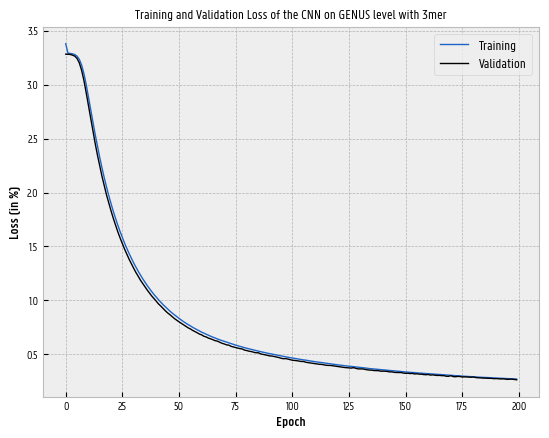

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

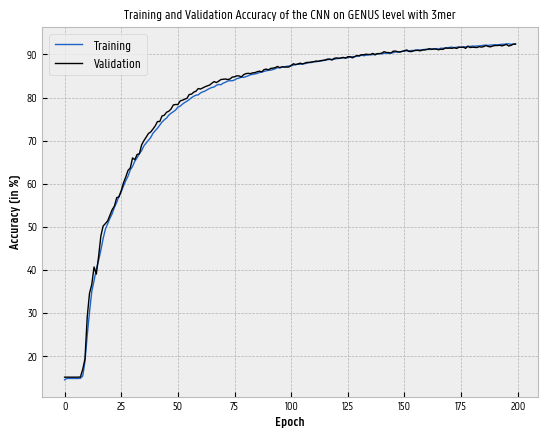

Training, validation and testing on GENUS level with 3mer is completed.


In [ ]:
CNNK('3mer', 'GENUS', 200)

# 4mer

Initiating training, validation and testing on PHYLUM level with 4mer.
Model constructed...
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 0.8949, Training Accuracy: 70.16%
Epoch [1] Validation Loss: 0.8741, Validation Accuracy: 69.72%
Epoch [2] Training Loss: 0.8627, Training Accuracy: 70.81%
Epoch [2] Validation Loss: 0.8722, Validation Accuracy: 69.72%
Epoch [3] Training Loss: 0.8598, Training Accuracy: 70.81%
Epoch [3] Validation Loss: 0.8664, Validation Accuracy: 69.72%
Epoch [4] Training Loss: 0.8487, Training Accuracy: 70.81%
Epoch [4] Validation Loss: 0.8476, Validation Accuracy: 69.72%
Epoch [5] Training Loss: 0.8195, Training Accuracy: 70.81%
Epoch [5] Validation Loss: 0.8046, Validation Accuracy: 69.72%
Epoch [6] Training Loss: 0.7653, Training Accuracy: 70.83%
Epoch [6] Validation Loss: 0.7354, Validation Accuracy: 70.48%
Epoch [7] Training Loss

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

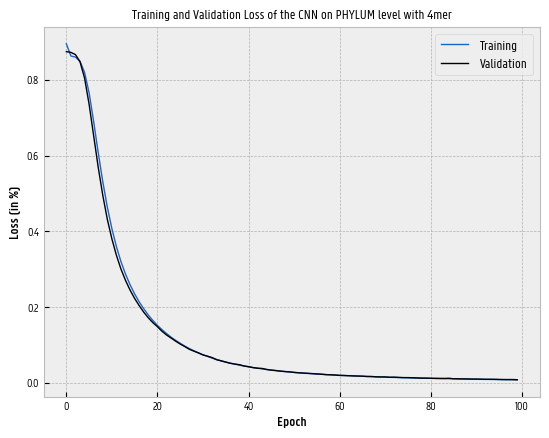

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

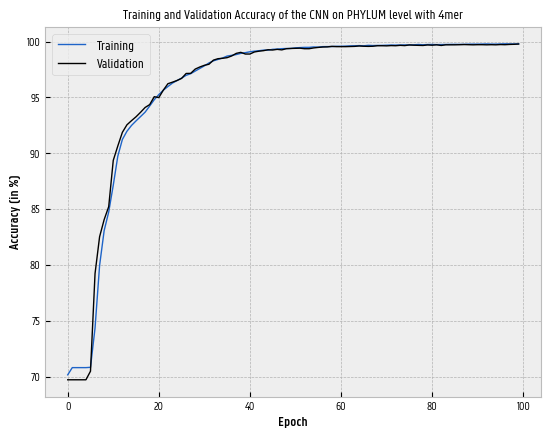

Training, validation and testing on PHYLUM level with 4mer is completed.


In [ ]:
CNNK('4mer', 'PHYLUM', 100)

Initiating training, validation and testing on CLASS level with 4mer.
Model constructed...
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 1.0823, Training Accuracy: 70.31%
Epoch [1] Validation Loss: 1.0833, Validation Accuracy: 69.72%
Epoch [2] Training Loss: 1.0579, Training Accuracy: 70.81%
Epoch [2] Validation Loss: 1.0823, Validation Accuracy: 69.72%
Epoch [3] Training Loss: 1.0565, Training Accuracy: 70.81%
Epoch [3] Validation Loss: 1.0750, Validation Accuracy: 69.72%
Epoch [4] Training Loss: 1.0486, Training Accuracy: 70.81%
Epoch [4] Validation Loss: 1.0647, Validation Accuracy: 69.72%
Epoch [5] Training Loss: 1.0260, Training Accuracy: 70.81%
Epoch [5] Validation Loss: 1.0259, Validation Accuracy: 69.72%
Epoch [6] Training Loss: 0.9761, Training Accuracy: 70.81%
Epoch [6] Validation Loss: 0.9629, Validation Accuracy: 69.72%
Epoch [7] Training Loss:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

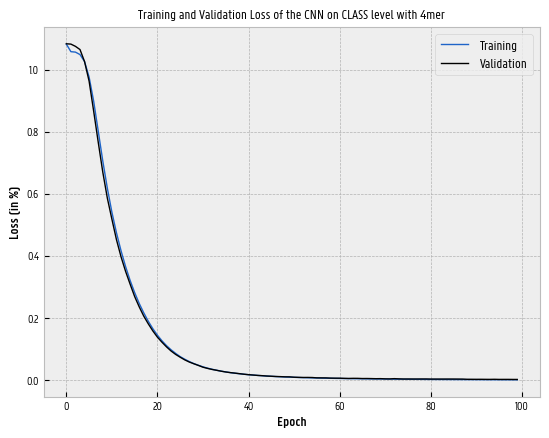

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

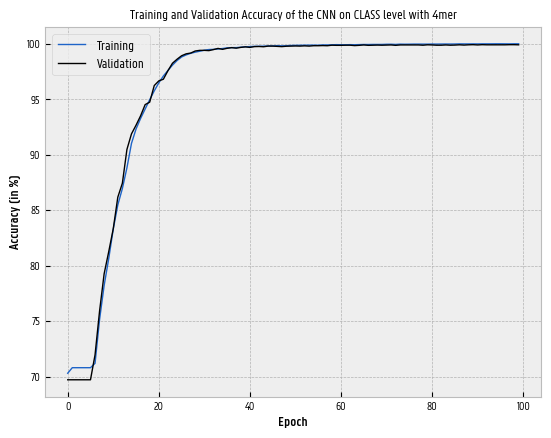

Training, validation and testing on CLASS level with 4mer is completed.


In [ ]:
CNNK('4mer', 'CLASS', 100)

Initiating training, validation and testing on ORDER level with 4mer.
Model constructed...
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 2.2844, Training Accuracy: 31.06%
Epoch [1] Validation Loss: 2.3058, Validation Accuracy: 29.61%
Epoch [2] Training Loss: 2.2687, Training Accuracy: 31.41%
Epoch [2] Validation Loss: 2.2887, Validation Accuracy: 29.61%
Epoch [3] Training Loss: 2.2417, Training Accuracy: 31.41%
Epoch [3] Validation Loss: 2.2373, Validation Accuracy: 29.61%
Epoch [4] Training Loss: 2.1475, Training Accuracy: 31.41%
Epoch [4] Validation Loss: 2.0922, Validation Accuracy: 29.67%
Epoch [5] Training Loss: 1.9680, Training Accuracy: 34.84%
Epoch [5] Validation Loss: 1.8827, Validation Accuracy: 37.56%
Epoch [6] Training Loss: 1.7485, Training Accuracy: 51.18%
Epoch [6] Validation Loss: 1.6542, Validation Accuracy: 57.50%
Epoch [7] Training Loss:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

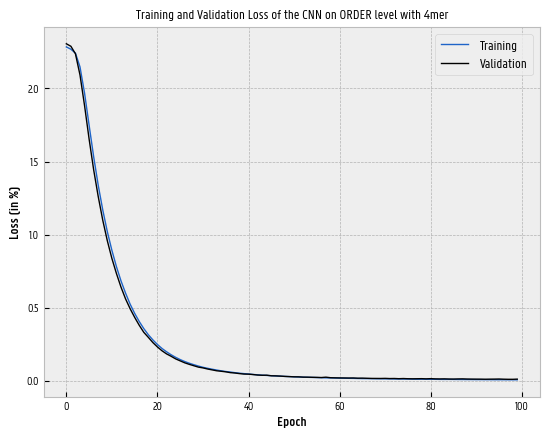

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

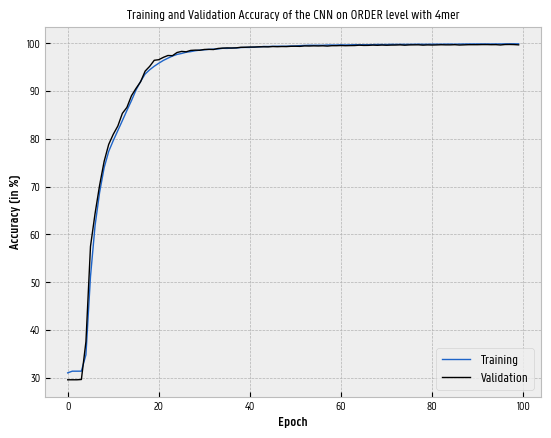

Training, validation and testing on ORDER level with 4mer is completed.


In [ ]:
CNNK('4mer', 'ORDER', 100)

Initiating training, validation and testing on FAMILY level with 4mer.
Model constructed...
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 3.3304, Training Accuracy: 13.94%
Epoch [1] Validation Loss: 3.2616, Validation Accuracy: 15.14%
Epoch [2] Training Loss: 3.2104, Training Accuracy: 14.84%
Epoch [2] Validation Loss: 3.1631, Validation Accuracy: 15.14%
Epoch [3] Training Loss: 3.1300, Training Accuracy: 14.84%
Epoch [3] Validation Loss: 3.0986, Validation Accuracy: 15.14%
Epoch [4] Training Loss: 3.0785, Training Accuracy: 14.84%
Epoch [4] Validation Loss: 3.0583, Validation Accuracy: 15.14%
Epoch [5] Training Loss: 3.0468, Training Accuracy: 14.84%
Epoch [5] Validation Loss: 3.0338, Validation Accuracy: 15.14%
Epoch [6] Training Loss: 3.0280, Training Accuracy: 14.84%
Epoch [6] Validation Loss: 3.0196, Validation Accuracy: 15.14%
Epoch [7] Training Loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.000     0.000     0.000       264
           1      0.000     0.000     0.000       185
           2      0.000     0.000     0.000       492
           3      0.000     0.000     0.000       142
           4      0.000     0.000     0.000       333
           5      0.000     0.000     0.000       722
           6      0.000     0.000     0.000        69
           7      0.000     0.000     0.000       178
           8      0.000     0.000     0.000       134
           9      0.000     0.000     0.000       343
          10      0.000     0.000     0.000       696
          11      0.000     0.000     0.000        79
          12      0.000     0.000     0.000       168
          13      0.000     0.000     0.000       116
          14      0.000     0.000     0.000        99
          15      0.000     0.000     0.000        68
          16      0.000     0.000     0.000       659
          17      0.000    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

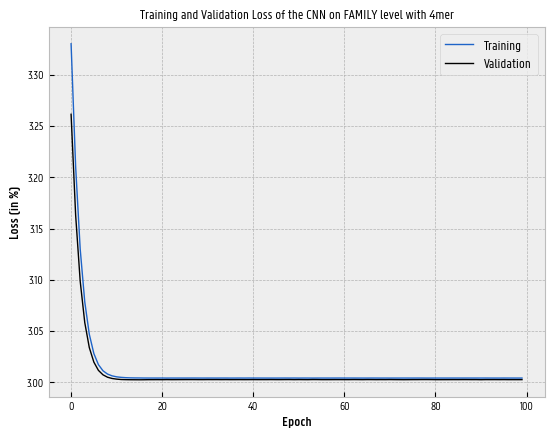

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

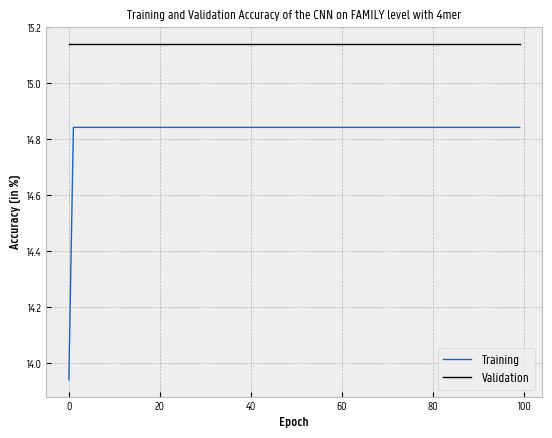

Training, validation and testing on FAMILY level with 4mer is completed.


In [ ]:
CNNK('4mer', 'FAMILY', 100)

In [ ]:
CNNK('4mer', 'GENUS', 100)

# 5mer

In [ ]:
CNNK('5mer', 'PHYLUM', 25)

In [ ]:
CNNK('5mer', 'CLASS', 25)

In [ ]:
CNNK('5mer', 'ORDER', 25)

In [ ]:
CNNK('5mer', 'FAMILY', 25)

In [ ]:
CNNK('5mer', 'GENUS', 25)